# Radar do Desenvolvimento Educacional
# Datathon POSTECH

Objetivo:
Analisar indicadores educacionais da ONG Passos Mágicos e
construir um modelo preditivo de risco de defasagem.

## Entregas:
### - Storytelling com gráficos (EDA)
### - Modelo Transversal (principal): risco de defasagem no ano atual
### - Modelo Longitudinal (diferencial): prever risco no ano seguinte

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier

import joblib

sns.set_theme(style="whitegrid")

### Carga dos dados

In [2]:
arquivo = "../data/raw/BASE DE DADOS PEDE 2024 - DATATHON.xlsx"

df_2022 = pd.read_excel(arquivo, sheet_name="PEDE2022")
df_2023 = pd.read_excel(arquivo, sheet_name="PEDE2023")
df_2024 = pd.read_excel(arquivo, sheet_name="PEDE2024")

In [3]:
df_2022["ANO"] = 2022
df_2023["ANO"] = 2023
df_2024["ANO"] = 2024

### Entendimento do dataset

### Aqui vamos:
#### - conferir colunas por ano
#### - medir quantos alunos existem por ano (RA e/ou NOME)
#### - medir o "overlap" (alunos que aparecem em anos consecutivos), que é o que viabiliza o modelo longitudinal

In [4]:
cols_22, cols_23, cols_24 = set(df_2022.columns), set(df_2023.columns), set(df_2024.columns)

print("Qtd colunas 2022:", len(cols_22))
print("Qtd colunas 2023:", len(cols_23))
print("Qtd colunas 2024:", len(cols_24))

print("\nColunas só 2022:", sorted(list(cols_22 - (cols_23 | cols_24)))[:30])
print("\nColunas só 2023:", sorted(list(cols_23 - (cols_22 | cols_24)))[:30])
print("\nColunas só 2024:", sorted(list(cols_24 - (cols_22 | cols_23)))[:30])

Qtd colunas 2022: 43
Qtd colunas 2023: 49
Qtd colunas 2024: 51

Colunas só 2022: ['Ano nasc', 'Defas', 'Fase ideal', 'Idade 22', 'Inglês', 'Matem', 'Nome', 'Portug']

Colunas só 2023: ['Destaque IPV.1', 'INDE 2023', 'Pedra 2023']

Colunas só 2024: ['Ativo/ Inativo', 'Ativo/ Inativo.1', 'Avaliador5', 'Avaliador6', 'Escola', 'INDE 2024', 'Pedra 2024']


In [5]:
# visão rápida de quantidade de registros por ano
print("Linhas 2022:", df_2022.shape)
print("Linhas 2023:", df_2023.shape)
print("Linhas 2024:", df_2024.shape)

Linhas 2022: (860, 43)
Linhas 2023: (1014, 49)
Linhas 2024: (1156, 51)


### Limpeza e tratamento

### Regras (conforme seu dicionário):
#### - Padronizar nomes finais em SNAKE_CASE (ex: DEFAS, FASE_IDEAL, INDE_23 etc.)
#### - Unificar as 3 abas em um df único
#### - Manter colunas históricas (INDE_22, INDE_23, INDE_24; PEDRA_20..PEDRA_24)
#### - Tratar duplicidades (ex.: "Ativo/ Inativo" repetido e "Destaque IPV" duplicado)

In [6]:
# --- DICIONÁRIOS POR ANO (SEGUINDO EXATAMENTE O QUE VOCÊ DEFINIU) ---

map_2022 = {
    "RA": "RA",
    "Fase": "FASE",
    "Turma": "TURMA",
    "Nome": "NOME",
    "Ano nasc": "ANO_NASC",
    "Idade 22": "IDADE",
    "Gênero": "GENERO",
    "Ano ingresso": "ANO_INGRESSO",
    "Instituição de ensino": "INST_ENSINO",
    "Pedra 20": "PEDRA_20",
    "Pedra 21": "PEDRA_21",
    "Pedra 22": "PEDRA_22",
    "INDE 22": "INDE_22",
    "Cg": "CG",
    "Cf": "CF",
    "Ct": "CT",
    "Nº Av": "N_AV",
    "Avaliador1": "AVALIADOR_1",
    "Rec Av1": "REC_AV1",
    "Avaliador2": "AVALIADOR_2",
    "Rec Av2": "REC_AV2",
    "Avaliador3": "AVALIADOR_3",
    "Rec Av3": "REC_AV3",
    "Avaliador4": "AVALIADOR_4",
    "Rec Av4": "REC_AV4",
    "IAA": "IAA",
    "IEG": "IEG",
    "IPS": "IPS",
    "Rec Psicologia": "REC_PSICOLOGIA",
    "IDA": "IDA",
    "Matem": "MATEM",
    "Portug": "PORTUG",
    "Inglês": "INGLES",
    "Indicado": "INDICADO",
    "Atingiu PV": "ATINGIU_PV",
    "IPV": "IPV",
    "IAN": "IAN",
    "Fase ideal": "FASE_IDEAL",
    "Defas": "DEFAS",
    "Destaque IEG": "DESTAQUE_IEG",
    "Destaque IDA": "DESTAQUE_IDA",
    "Destaque IPV": "DESTAQUE_IPV",
}

map_2023 = {
    "RA": "RA",
    "Fase": "FASE",
    "INDE 2023": "INDE_23",
    "INDE 23": "INDE_23",
    "Pedra 2023": "PEDRA_23",
    "Pedra 23": "PEDRA_23",
    "Turma": "TURMA",
    "Nome Anonimizado": "NOME",
    "Data de Nasc": "ANO_NASC",
    "Idade": "IDADE",
    "Gênero": "GENERO",
    "Ano ingresso": "ANO_INGRESSO",
    "Instituição de ensino": "INST_ENSINO",
    "Pedra 20": "PEDRA_20",
    "Pedra 21": "PEDRA_21",
    "Pedra 22": "PEDRA_22",
    "INDE 22": "INDE_22",
    "Cg": "CG",
    "Cf": "CF",
    "Ct": "CT",
    "Nº Av": "N_AV",
    "Avaliador1": "AVALIADOR_1",
    "Rec Av1": "REC_AV1",
    "Avaliador2": "AVALIADOR_2",
    "Rec Av2": "REC_AV2",
    "Avaliador3": "AVALIADOR_3",
    "Rec Av3": "REC_AV3",
    "Avaliador4": "AVALIADOR_4",
    "Rec Av4": "REC_AV4",
    "IAA": "IAA",
    "IEG": "IEG",
    "IPS": "IPS",
    "IPP": "IPP",
    "Rec Psicologia": "REC_PSICOLOGIA",
    "IDA": "IDA",
    "Mat": "MATEM",
    "Por": "PORTUG",
    "Ing": "INGLES",
    "Indicado": "INDICADO",
    "Atingiu PV": "ATINGIU_PV",
    "IPV": "IPV",
    "IAN": "IAN",
    "Fase Ideal": "FASE_IDEAL",
    "Defasagem": "DEFAS",
    "Destaque IEG": "DESTAQUE_IEG",
    "Destaque IDA": "DESTAQUE_IDA",
    "Destaque IPV": "DESTAQUE_IPV",
    "Destaque IPV.1": "DESTAQUE_IPV",
}

map_2024 = {
    "RA": "RA",
    "Fase": "FASE",
    "INDE 2024": "INDE_24",
    "Pedra 2024": "PEDRA_24",
    "Turma": "TURMA",
    "Nome Anonimizado": "NOME",
    "Data de Nasc": "ANO_NASC",
    "Idade": "IDADE",
    "Gênero": "GENERO",
    "Ano ingresso": "ANO_INGRESSO",
    "Instituição de ensino": "INST_ENSINO",
    "Pedra 20": "PEDRA_20",
    "Pedra 21": "PEDRA_21",
    "Pedra 22": "PEDRA_22",
    "Pedra 23": "PEDRA_23",
    "INDE 22": "INDE_22",
    "INDE 23": "INDE_23",
    "Cg": "CG",
    "Cf": "CF",
    "Ct": "CT",
    "Nº Av": "N_AV",
    "Avaliador1": "AVALIADOR_1",
    "Rec Av1": "REC_AV1",
    "Avaliador2": "AVALIADOR_2",
    "Rec Av2": "REC_AV2",
    "Avaliador3": "AVALIADOR_3",
    "Rec Av3": "REC_AV3",
    "Avaliador4": "AVALIADOR_4",
    "Rec Av4": "REC_AV4",
    "Avaliador5": "AVALIADOR_5",
    "Avaliador6": "AVALIADOR_6",
    "IAA": "IAA",
    "IEG": "IEG",
    "IPS": "IPS",
    "IPP": "IPP",
    "Rec Psicologia": "REC_PSICOLOGIA",
    "IDA": "IDA",
    "Mat": "MATEM",
    "Por": "PORTUG",
    "Ing": "INGLES",
    "Indicado": "INDICADO",
    "Atingiu PV": "ATINGIU_PV",
    "IPV": "IPV",
    "IAN": "IAN",
    "Fase Ideal": "FASE_IDEAL",
    "Defasagem": "DEFAS",
    "Destaque IEG": "DESTAQUE_IEG",
    "Destaque IDA": "DESTAQUE_IDA",
    "Destaque IPV": "DESTAQUE_IPV",
    "Escola": "ESCOLA",
    "Ativo/ Inativo": "ATIVO_INATIVO",
    "Ativo/ Inativo.1": "ATIVO_INATIVO",
}

In [7]:
def padronizar_df(df, mapping, ano):
    df = df.copy()
    # renomear
    df = df.rename(columns=mapping)

    # remover duplicidade de colunas (pandas às vezes cria colunas repetidas com ".1")
    df = df.loc[:, ~df.columns.duplicated()]

    # garantir ANO
    if "ANO" not in df.columns:
        df["ANO"] = ano

    return df

df_2022 = padronizar_df(df_2022, map_2022, 2022)
df_2023 = padronizar_df(df_2023, map_2023, 2023)
df_2024 = padronizar_df(df_2024, map_2024, 2024)

# coluna padrão final: união de tudo
todas_colunas = sorted(list(set(df_2022.columns) | set(df_2023.columns) | set(df_2024.columns)))

def ajustar_colunas(df, colunas):
    df = df.copy()
    for col in colunas:
        if col not in df.columns:
            df[col] = np.nan
    return df[colunas]

df_2022 = ajustar_colunas(df_2022, todas_colunas)
df_2023 = ajustar_colunas(df_2023, todas_colunas)
df_2024 = ajustar_colunas(df_2024, todas_colunas)

# df unificado
df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

# limpeza básica
df = df.drop_duplicates()

# tipos numéricos (tenta converter o que for numérico)
num_cols_candidates = ["IAN","IDA","IEG","IAA","IPS","IPP","IPV","DEFAS","MATEM","PORTUG","INGLES","IDADE",
                      "INDE_22","INDE_23","INDE_24"]
for c in num_cols_candidates:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

### Feature Engineering

### Target definido:
#### - RISCO = 1 se DEFAS < 0 (aluno defasado)
#### - RISCO = 0 se DEFAS >= 0

### Também vamos criar:
#### - INDE_ATUAL (coluna do INDE correspondente ao ano da linha)
#### - Faixa de defasagem (para storytelling: severa/moderada/adequada)

In [8]:
df["RISCO"] = np.where(df["DEFAS"] < 0, 1, 0)

In [9]:
# INDE do ano atual
df["INDE_ATUAL"] = np.select(
    [
        df["ANO"].eq(2022),
        df["ANO"].eq(2023),
        df["ANO"].eq(2024),
    ],
    [
        df.get("INDE_22", np.nan),
        df.get("INDE_23", np.nan),
        df.get("INDE_24", np.nan),
    ],
    default=np.nan
)

In [10]:
df["FAIXA_DEFASAGEM"] = np.select(
    [
        df["DEFAS"] <= -3,
        (df["DEFAS"] >= -2) & (df["DEFAS"] <= -1),
        df["DEFAS"] >= 0
    ],
    ["Severa", "Moderada", "Adequada/Adiantada"],
    default="Sem dado"
)

In [11]:
# Tempo no programa (para usar como feature)
df["TEMPO_PM"] = df["ANO"] - df["ANO_INGRESSO"]

### Análise exploratória

#### Gráficos para storytelling respondendo às perguntas:
##### 1) IAN/Defasagem: perfil e evolução por ano
##### 2) IDA: evolução por ano e por fase
##### 3) IEG vs IDA e relação com IPV/ATINGIU_PV
##### 4) IAA vs IDA/IEG
##### 5) IPS como sinal antecedente (usaremos também o dataset longitudinal como reforço)
##### 6) IPP vs IAN/DEFAS
##### 7) Drivers do IPV (correlação e boxplots)
##### 8) Combinações elevando INDE
##### 10) Efetividade por fases (Quartzo/Ágata/Ametista/Topázio → via FASE)

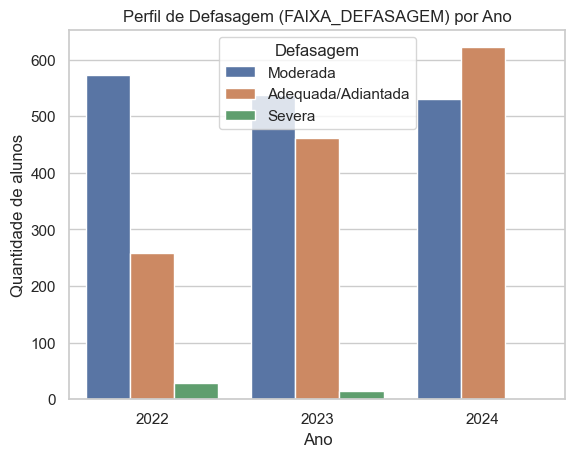

In [12]:
plt.figure()
sns.countplot(data=df, x="ANO", hue="FAIXA_DEFASAGEM")
plt.title("Perfil de Defasagem (FAIXA_DEFASAGEM) por Ano")
plt.xlabel("Ano")
plt.ylabel("Quantidade de alunos")
plt.legend(title="Defasagem")
plt.show()

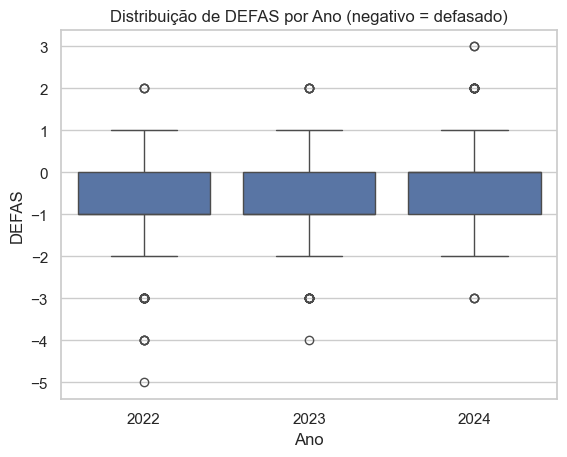

In [13]:
plt.figure()
sns.boxplot(data=df, x="ANO", y="DEFAS")
plt.title("Distribuição de DEFAS por Ano (negativo = defasado)")
plt.xlabel("Ano")
plt.ylabel("DEFAS")
plt.show()

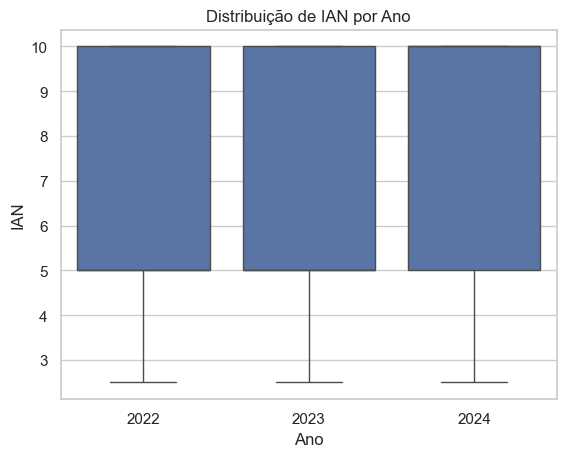

In [14]:
plt.figure()
sns.boxplot(data=df, x="ANO", y="IAN")
plt.title("Distribuição de IAN por Ano")
plt.xlabel("Ano")
plt.ylabel("IAN")
plt.show()

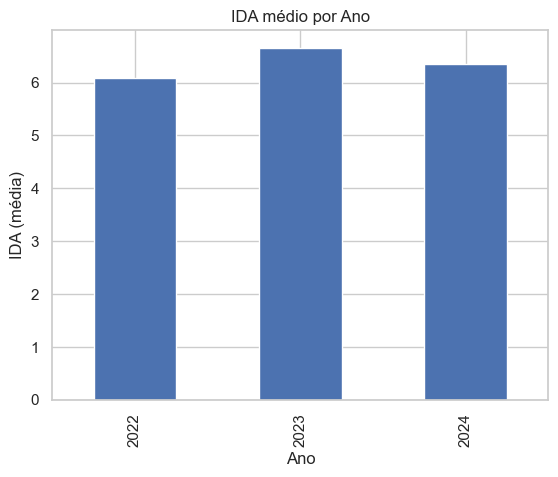

In [15]:
# Evolução de IDA por ano
ida_ano = df.groupby("ANO", dropna=True)["IDA"].mean()
plt.figure()
ida_ano.plot(kind="bar")
plt.title("IDA médio por Ano")
plt.xlabel("Ano")
plt.ylabel("IDA (média)")
plt.show()

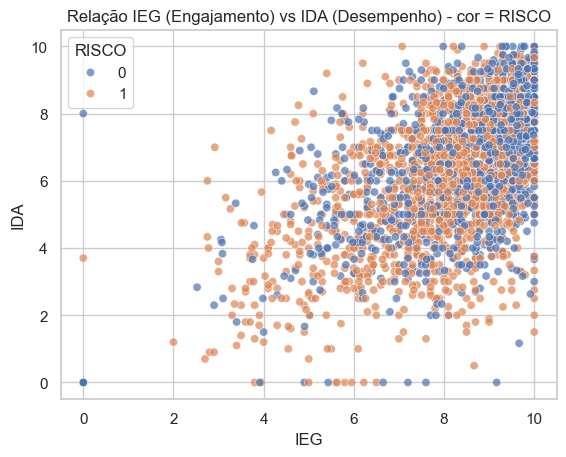

In [16]:
# Engajamento (IEG) vs Desempenho (IDA)
plt.figure()
sns.scatterplot(data=df, x="IEG", y="IDA", hue="RISCO", alpha=0.7)
plt.title("Relação IEG (Engajamento) vs IDA (Desempenho) - cor = RISCO")
plt.xlabel("IEG")
plt.ylabel("IDA")
plt.show()

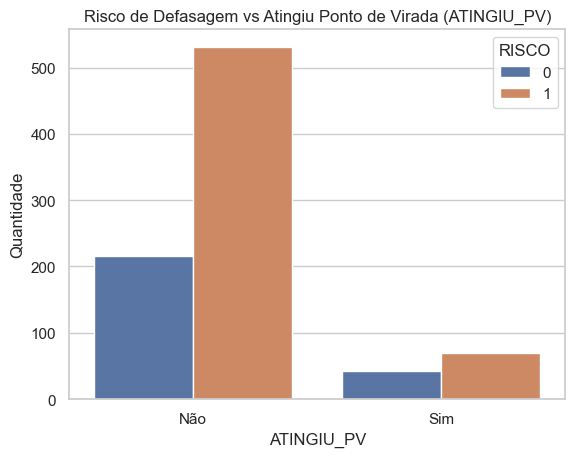

In [17]:
# Risco por ATINGIU_PV (ponto de virada)
if "ATINGIU_PV" in df.columns:
    plt.figure()
    sns.countplot(data=df, x="ATINGIU_PV", hue="RISCO")
    plt.title("Risco de Defasagem vs Atingiu Ponto de Virada (ATINGIU_PV)")
    plt.xlabel("ATINGIU_PV")
    plt.ylabel("Quantidade")
    plt.show()

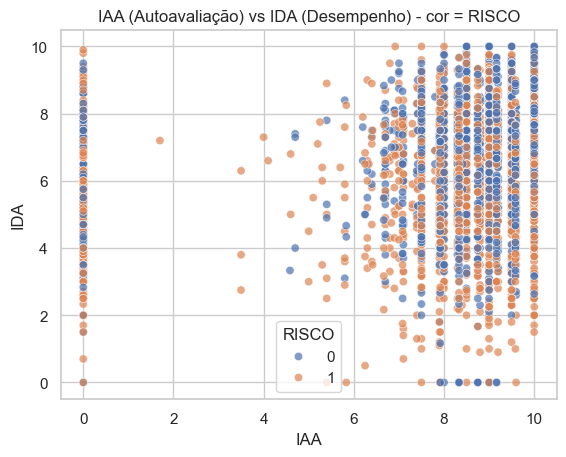

In [18]:
# Autoavaliação (IAA) vs realidade (IDA) e engajamento (IEG)
plt.figure()
sns.scatterplot(data=df, x="IAA", y="IDA", hue="RISCO", alpha=0.7)
plt.title("IAA (Autoavaliação) vs IDA (Desempenho) - cor = RISCO")
plt.xlabel("IAA")
plt.ylabel("IDA")
plt.show()

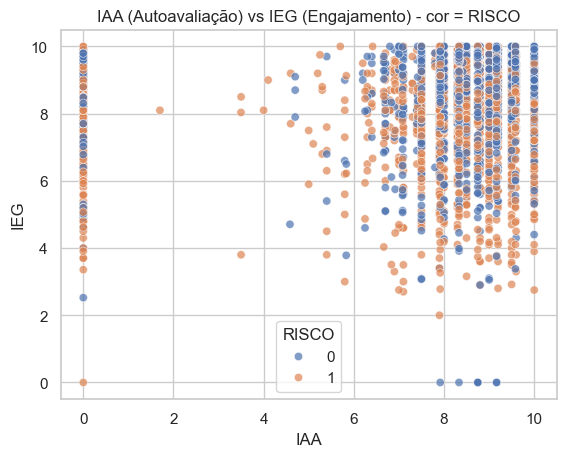

In [19]:
plt.figure()
sns.scatterplot(data=df, x="IAA", y="IEG", hue="RISCO", alpha=0.7)
plt.title("IAA (Autoavaliação) vs IEG (Engajamento) - cor = RISCO")
plt.xlabel("IAA")
plt.ylabel("IEG")
plt.show()

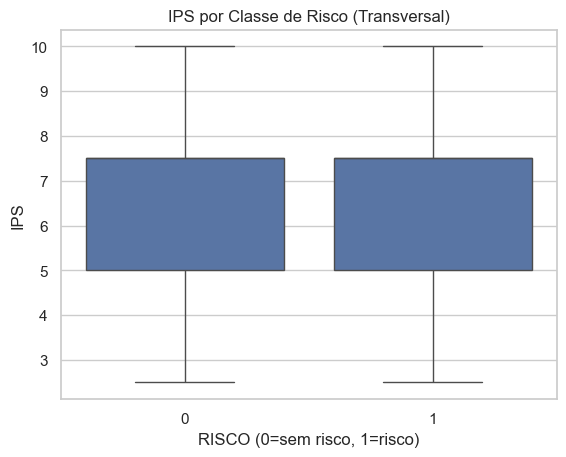

In [20]:
# IPS e risco (visão transversal)
plt.figure()
sns.boxplot(data=df, x="RISCO", y="IPS")
plt.title("IPS por Classe de Risco (Transversal)")
plt.xlabel("RISCO (0=sem risco, 1=risco)")
plt.ylabel("IPS")
plt.show()

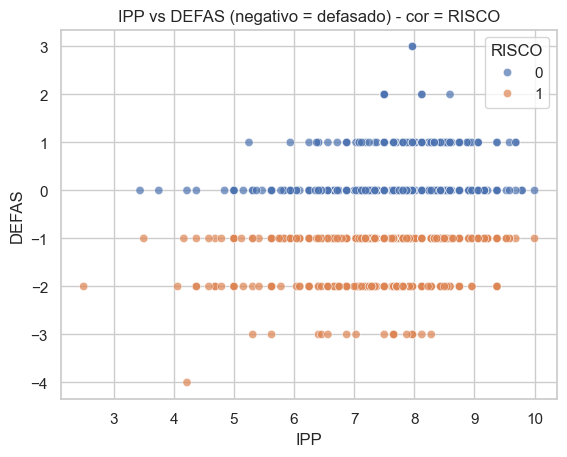

In [21]:
# IPP confirmando/contradizendo defasagem (onde existir IPP)
if "IPP" in df.columns:
    df_ipp = df.dropna(subset=["IPP"])
    plt.figure()
    sns.scatterplot(data=df_ipp, x="IPP", y="DEFAS", hue="RISCO", alpha=0.7)
    plt.title("IPP vs DEFAS (negativo = defasado) - cor = RISCO")
    plt.xlabel("IPP")
    plt.ylabel("DEFAS")
    plt.show()

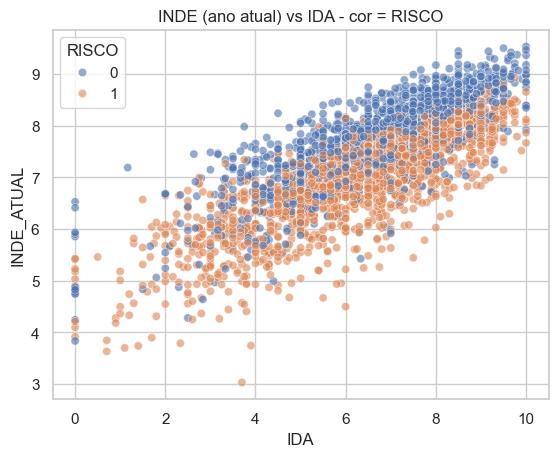

In [22]:
# Multidimensionalidade: INDE vs combinação de indicadores
base_inde = df.dropna(subset=["INDE_ATUAL","IDA","IEG","IPS"])
plt.figure()
sns.scatterplot(data=base_inde, x="IDA", y="INDE_ATUAL", hue="RISCO", alpha=0.6)
plt.title("INDE (ano atual) vs IDA - cor = RISCO")
plt.xlabel("IDA")
plt.ylabel("INDE_ATUAL")
plt.show()

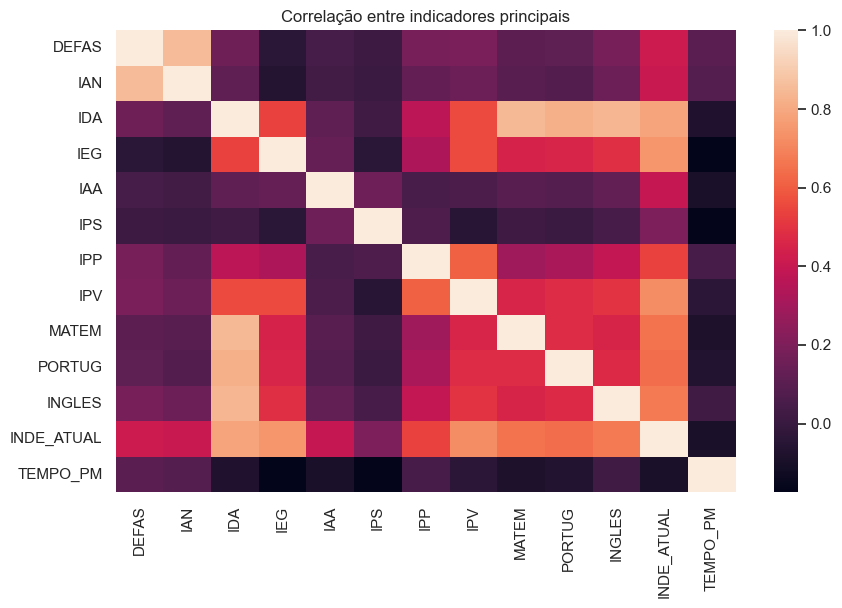

In [23]:
# Heatmap de correlação (somente colunas numéricas principais)
corr_cols = [c for c in ["DEFAS","IAN","IDA","IEG","IAA","IPS","IPP","IPV","MATEM","PORTUG","INGLES","INDE_ATUAL","TEMPO_PM"] if c in df.columns]
corr_df = df[corr_cols].corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr_df, annot=False)
plt.title("Correlação entre indicadores principais")
plt.show()

### Preparação ML

#### Vamos treinar 2 modelos:
##### - Modelo 1 (principal, transversal): prever RISCO no mesmo ano
##### - Modelo 2 (diferencial, longitudinal): usar ano t para prever RISCO em t+1

##### Importante: para evitar "vazamento", não usamos DEFAS (target) como feature.
##### Também evitamos usar FASE_IDEAL/FASE diretamente no modelo principal, pois podem estar muito próximas do cálculo de DEFAS.

In [24]:
# Features candidatas (núcleo consistente)
features_base = ["IAA","IEG","IPS","IDA","IPV","MATEM","PORTUG","INGLES","IDADE","TEMPO_PM"]

# IPP só existe em 2023/2024; podemos usar com imputação para o transversal
if "IPP" in df.columns:
    features_base.append("IPP")

# Garantir que só pegamos colunas existentes
features_base = [f for f in features_base if f in df.columns]

# Filtrar linhas que tenham target e pelo menos parte das features
df_ml = df.dropna(subset=["RISCO"]).copy()

# imputação simples (para ML baseline): mediana nas numéricas
for col in features_base:
    if df_ml[col].dtype != "O":
        df_ml[col] = df_ml[col].fillna(df_ml[col].median())

X = df_ml[features_base]
y = df_ml["RISCO"]

In [25]:
print("Distribuição do target:")
print(df_ml["RISCO"].value_counts())
print(df_ml["RISCO"].value_counts(normalize=True))

Distribuição do target:
RISCO
1    1687
0    1343
Name: count, dtype: int64
RISCO
1    0.556766
0    0.443234
Name: proportion, dtype: float64


In [26]:
# Split transversal (estratificado)
df_train = df_ml[df_ml["ANO"] < 2024]
df_test  = df_ml[df_ml["ANO"] == 2024]

X_train = df_train[features_base]
y_train = df_train["RISCO"]

X_test  = df_test[features_base]
y_test  = df_test["RISCO"]

print("Treino:", df_train.shape)
print("Teste :", df_test.shape)

Treino: (1874, 56)
Teste : (1156, 56)


### Treinamento do modelo

#### Modelo 1: Transversal (principal)

In [27]:
scale_pos_weight = (
    df_train["RISCO"].value_counts()[0] /
    df_train["RISCO"].value_counts()[1]
)

model_transversal = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)


model_transversal.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

### Avaliação
 
#### Avaliação do Modelo 1 (Transversal)

=== Classification Report (Transversal) ===
              precision    recall  f1-score   support

           0       0.82      0.59      0.68       622
           1       0.64      0.85      0.73       534

    accuracy                           0.71      1156
   macro avg       0.73      0.72      0.71      1156
weighted avg       0.74      0.71      0.71      1156


Matriz de Confusão (Transversal):
[[364 258]
 [ 78 456]]

ROC AUC (Transversal): 0.7750852029818033


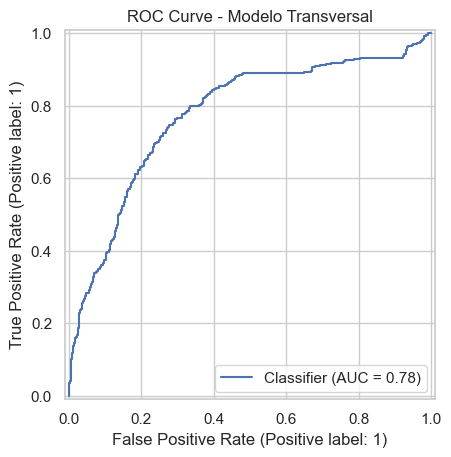

In [28]:
pred = model_transversal.predict(X_test)
proba = model_transversal.predict_proba(X_test)[:,1]

print("=== Classification Report (Transversal) ===")
print(classification_report(y_test, pred))

print("\nMatriz de Confusão (Transversal):")
print(confusion_matrix(y_test, pred))

print("\nROC AUC (Transversal):", roc_auc_score(y_test, proba))

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve - Modelo Transversal")
plt.show()

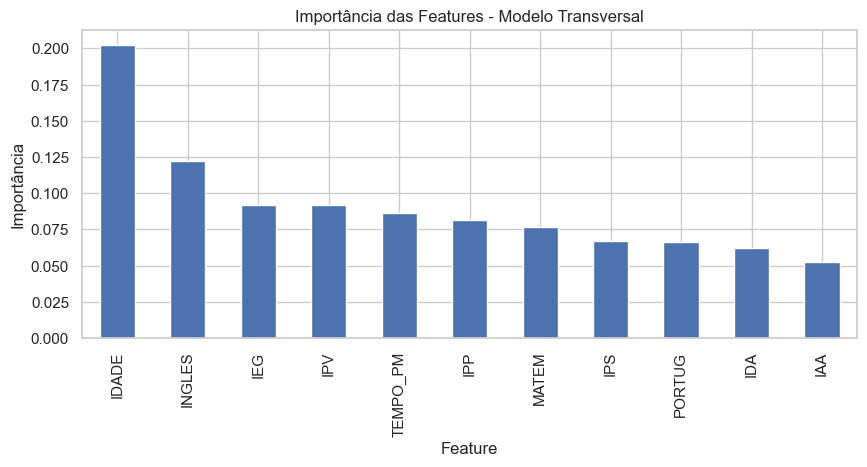

In [29]:
# Importância das features (ótimo para storytelling)
importances = pd.Series(model_transversal.feature_importances_, index=features_base).sort_values(ascending=False)

plt.figure(figsize=(10,4))
importances.plot(kind="bar")
plt.title("Importância das Features - Modelo Transversal")
plt.xlabel("Feature")
plt.ylabel("Importância")
plt.show()

### Salvamento do modelo
 
#### Salvaremos:
#### - Modelo transversal (principal)
#### - Lista de features usada (para o Streamlit)

In [30]:
joblib.dump(
    {"model": model_transversal, "features": features_base},
    "../models/modelo_risco_transversal.pkl"
)

['../models/modelo_risco_transversal.pkl']

### (DIFERENCIAL) Modelo Longitudinal
 
#### Ideia:
#### - usar dados do ano t como features
#### - prever risco no ano t+1

#### Construímos pares:
#### 2022 → 2023
#### 2023 → 2024

#### Vamos usar RA como chave principal (mais estável que nome).
#### Linhas sem RA não entram no longitudinal.

In [31]:
# Base com RA válido
df_ra = df_ml.dropna(subset=["RA"]).copy()

# selecionar apenas colunas necessárias para montar pares
cols_needed = ["RA","ANO","RISCO"] + features_base
df_ra = df_ra[cols_needed].copy()

# ordenar e criar pares por RA
df_ra = df_ra.sort_values(["RA","ANO"])

# criar "ano seguinte"
df_t = df_ra.copy()
df_t1 = df_ra.copy()
df_t1["ANO"] = df_t1["ANO"] - 1  # para juntar t com t+1

pairs = df_t.merge(
    df_t1,
    on=["RA","ANO"],
    suffixes=("_t","_t1"),
    how="inner"
)

# target do longitudinal = risco no ano seguinte (t1)
pairs["RISCO_PROX_ANO"] = pairs["RISCO_t1"]

print("Pares longitudinais (linhas):", pairs.shape[0])
print("Alunos únicos (RA) nos pares:", pairs["RA"].nunique())

Pares longitudinais (linhas): 1365
Alunos únicos (RA) nos pares: 897


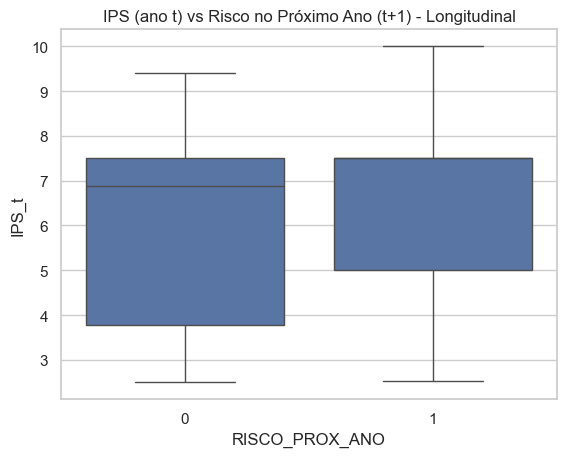

In [32]:
# EDA longitudinal rápida (IPS antecedendo risco)
if "IPS_t" in pairs.columns:
    plt.figure()
    sns.boxplot(data=pairs, x="RISCO_PROX_ANO", y="IPS_t")
    plt.title("IPS (ano t) vs Risco no Próximo Ano (t+1) - Longitudinal")
    plt.xlabel("RISCO_PROX_ANO")
    plt.ylabel("IPS_t")
    plt.show()

In [33]:
# Treino/test split longitudinal por GRUPO (RA) para evitar mesmo aluno em treino e teste
feature_cols_long = [c for c in pairs.columns if c.endswith("_t") and any(base in c for base in features_base)]
X_long = pairs[feature_cols_long].copy()
y_long = pairs["RISCO_PROX_ANO"].copy()
groups = pairs["RA"].copy()

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_long, y_long, groups=groups))

Xl_train, Xl_test = X_long.iloc[train_idx], X_long.iloc[test_idx]
yl_train, yl_test = y_long.iloc[train_idx], y_long.iloc[test_idx]

model_longitudinal = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss"
)

model_longitudinal.fit(Xl_train, yl_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

=== Classification Report (Longitudinal) ===
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       155
           1       0.70      0.74      0.72       126

    accuracy                           0.74       281
   macro avg       0.74      0.74      0.74       281
weighted avg       0.75      0.74      0.74       281


Matriz de Confusão (Longitudinal):
[[116  39]
 [ 33  93]]

ROC AUC (Longitudinal): 0.8304659498207885


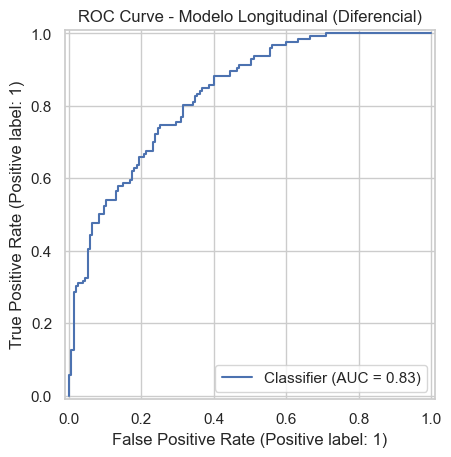

In [34]:
pred_l = model_longitudinal.predict(Xl_test)
proba_l = model_longitudinal.predict_proba(Xl_test)[:,1]

print("=== Classification Report (Longitudinal) ===")
print(classification_report(yl_test, pred_l))

print("\nMatriz de Confusão (Longitudinal):")
print(confusion_matrix(yl_test, pred_l))

print("\nROC AUC (Longitudinal):", roc_auc_score(yl_test, proba_l))

RocCurveDisplay.from_predictions(yl_test, proba_l)
plt.title("ROC Curve - Modelo Longitudinal (Diferencial)")
plt.show()

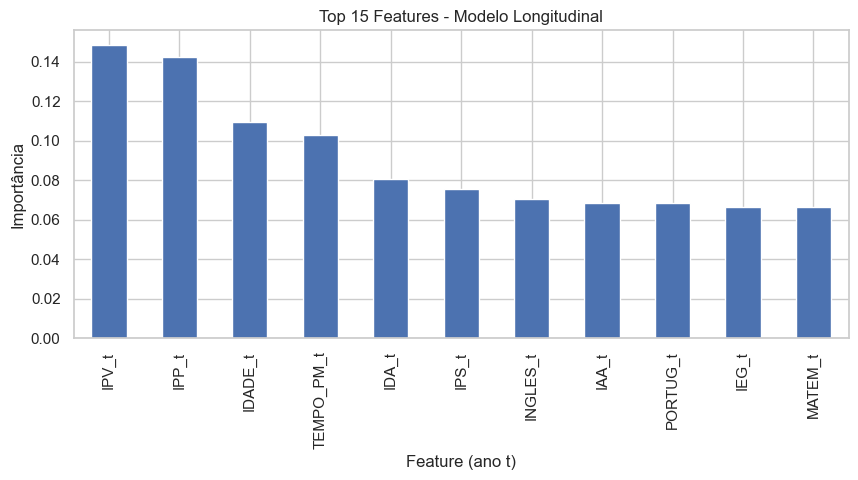

In [35]:
# Importância features longitudinal
importances_l = pd.Series(model_longitudinal.feature_importances_, index=feature_cols_long).sort_values(ascending=False)

plt.figure(figsize=(10,4))
importances_l.head(15).plot(kind="bar")
plt.title("Top 15 Features - Modelo Longitudinal")
plt.xlabel("Feature (ano t)")
plt.ylabel("Importância")
plt.show()

In [36]:
# salvar modelo longitudinal e features correspondentes
joblib.dump(
    {"model": model_longitudinal, "features": feature_cols_long},
    "../models/modelo_risco_longitudinal.pkl"
)

['../models/modelo_risco_longitudinal.pkl']

In [40]:
df.to_csv("../app/data/base_consolidada.csv", index=False)